## Задание 4

Необходимо произвести предобработку данных,
обучить модели на алгоритмах, рассмотренных в уроках,
оценить модели с помощью рассмотренных метрик и объяснить выбор определенной метрики.

Критерий оценки - Балл (max 10)

Предобработка данных - 3;

Обучение моделей - 4;

Выбор метрики и оценка моделей - 3


## Решение
рассмотренные в уроках алгоритмы это: LinearRegression, Ridge, Lasso, HuberRegressor

рассмотренные метрики: MSE, MAE, MAPE, R^2

### Предобработка данных

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [146]:
df = pd.read_csv('./data/house_prices_train.csv')

По условиям задачи никакого описания набора данных не дано, поэтому смысловой анализ данных опустим. 
Для начала нужно избавиться от пропусков и категориальных признаков. Посмотрим на них, и оценим, можно ли их закодировать.

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [148]:
# столбцы с пропусками данных > 20% просто удаляем, для заполнения пропущенных значений нет экспертизы
col_to_drop = df.columns[df.isnull().sum() > df.shape[0]*0.2]
df.drop(col_to_drop, axis = 1, inplace=True)   

df.drop(['Id'], axis = 1, inplace=True) 

In [149]:
# строки с пропущенными значениями тоже
df = df.dropna() 
df.reset_index(drop=True, inplace=True)

<AxesSubplot:>

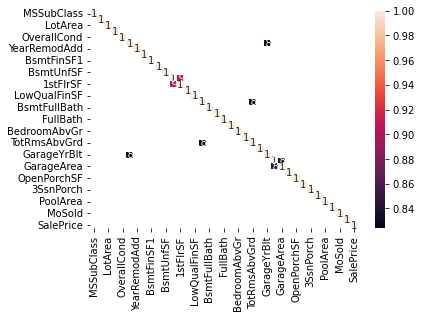

In [150]:
#теперь проверим взаимную корреляцию
import seaborn as sns


#plt.figure(figsize=(10, 10))
sns.heatmap(df.corr()[df.corr() > 0.8], annot=True)

Видно, что есть пары коррелированных между собой переменных

In [151]:
corr = df.corr()[df.corr() > 0.8]

In [152]:
# выведем их список
for index, row in corr.iterrows():
    for col in corr.columns:
        if not np.isnan(row[col]):
            if index != col:
                print(index, '<>' ,col)

YearBuilt <> GarageYrBlt
TotalBsmtSF <> 1stFlrSF
1stFlrSF <> TotalBsmtSF
GrLivArea <> TotRmsAbvGrd
TotRmsAbvGrd <> GrLivArea
GarageYrBlt <> YearBuilt
GarageCars <> GarageArea
GarageArea <> GarageCars


In [153]:
# удалим коррелированные столбцы
df.drop(['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd', 'GarageCars'], axis = 1, inplace=True) 

<AxesSubplot:>

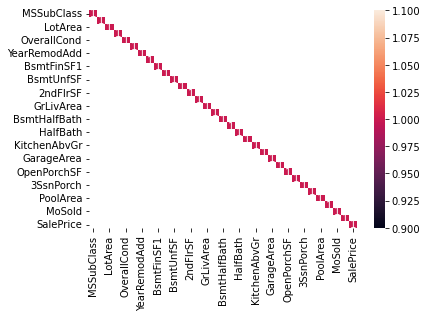

In [154]:
sns.heatmap(df.corr()[df.corr() > 0.8], annot=True)

In [155]:
# теперь посмотрим на категориальные признаки
col_to_transform = []
for col in df.columns:
    if df[col].dtype == object:
        df[col] = df[col].astype('category') # конвертируем в правильный тип данных
        col_to_transform.append(col)
        print(col, len(df[col].unique()))

MSZoning 5
Street 2
LotShape 4
LandContour 4
Utilities 1
LotConfig 5
LandSlope 3
Neighborhood 25
Condition1 9
Condition2 6
BldgType 5
HouseStyle 8
RoofStyle 5
RoofMatl 7
Exterior1st 14
Exterior2nd 16
MasVnrType 4
ExterQual 4
ExterCond 4
Foundation 5
BsmtQual 4
BsmtCond 4
BsmtExposure 4
BsmtFinType1 6
BsmtFinType2 6
Heating 4
HeatingQC 5
CentralAir 2
Electrical 5
KitchenQual 4
Functional 6
GarageType 6
GarageFinish 3
GarageQual 5
GarageCond 5
PavedDrive 3
SaleType 9
SaleCondition 6


In [156]:
# большинство категориальных признаков имеют менее 10 уникальных значений, поэтому перекодируем их в отдельные столбцы

from sklearn.preprocessing import OneHotEncoder

for col in col_to_transform:
    enc = OneHotEncoder()
    arr = np.array(df[col])
    data_new = enc.fit_transform(arr.reshape(-1, 1))
    new_df = pd.DataFrame(data_new.toarray(), columns=[col + '-' + cat for cat in enc.categories_])
    df = df.join(new_df)

df.drop(col_to_transform, axis = 1, inplace=True) 


In [157]:
df.shape
    

(1094, 256)

### Обучение моделей

In [158]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


models = []
mse_scr = []
mae_scr = []
mape_scr = []
r2_scr = []

def try_model(model, X_train, y_train, X_test, y_test, model_params=None, add_stat=True):
    if model_params is None:
        model_params = dict()

    pipeline = make_pipeline(StandardScaler(), model(**model_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    model_name = model.__name__
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(model_name)
    print('mse =', mse)
    print('mae =', mae)
    print('mape =', mape)
    print('R2 =', r2)

    if add_stat:
        models.append(model_name)
        mse_scr.append(mse)
        mae_scr.append(mae)
        mape_scr.append(mape)
        r2_scr.append(r2)



In [159]:
X = df.drop('SalePrice', axis=1).to_numpy()
y = df['SalePrice'].to_numpy()

In [160]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [161]:
try_model(LinearRegression, X_train, y_train, X_test, y_test, add_stat=False)

LinearRegression
mse = 7.254662445937457e+32
mae = 3164710248782814.0
mape = 16940469742.191435
R2 = -1.1574876941147445e+23


In [162]:
try_model(Ridge, X_train, y_train, X_test, y_test)

Ridge
mse = 604988955.4562668
mae = 16667.183244302832
mape = 0.0996921320591224
R2 = 0.9034734867081093


In [163]:
try_model(Lasso, X_train, y_train, X_test, y_test)

Lasso
mse = 572374951.0376154
mae = 16591.575762066324
mape = 0.09953735850912022
R2 = 0.908677079439227


/home/danil/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9369129552.973083, tolerance: 583743228.9053506
  model = cd_fast.enet_coordinate_descent(


In [164]:
try_model(HuberRegressor, X_train, y_train, X_test, y_test)

HuberRegressor
mse = 582388808.9940921
mae = 14829.92643646958
mape = 0.08601230124493746
R2 = 0.9070793597049718


/home/danil/.local/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


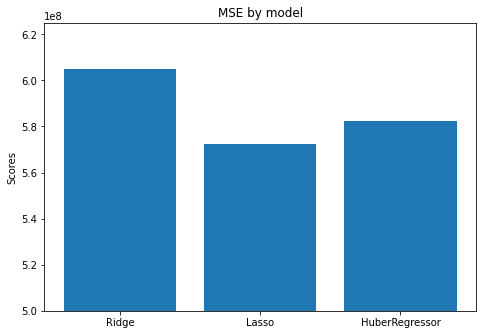

In [165]:
#Визуализация MSE
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models,mse_scr)
ax.set_ylim(5E+8, 6.25E+8)
ax.set_ylabel('Scores')
ax.set_title('MSE by model')
plt.show()

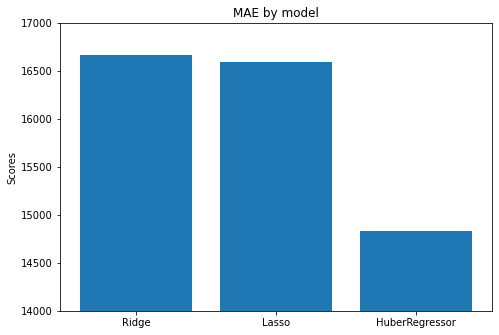

In [166]:
#Визуализация MAE
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models,mae_scr)
ax.set_ylim(1.4E+4, 1.7E+4)
ax.set_ylabel('Scores')
ax.set_title('MAE by model')
plt.show()

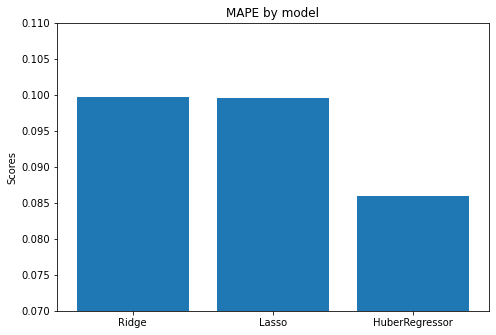

In [167]:
#Визуализация MAPE
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models,mape_scr)
ax.set_ylim(0.07, 0.11)
ax.set_ylabel('Scores')
ax.set_title('MAPE by model')
plt.show()

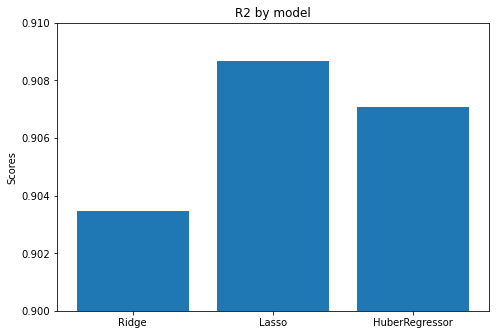

In [168]:
#Визуализация R2
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(models,r2_scr)
ax.set_ylim(0.9, 0.91)
ax.set_ylabel('Scores')
ax.set_title('R2 by model')
plt.show()

В метериалах лекции сказано: "...метрики, как правило, определяются в процессе постановки задачи...". Т.к. в постановке задачи про метрики ничего не сказано, то мой выбор это R2. Во первых, эта метрика безразмерная, а во вторых именно в данной задаче она позволяет выбрать единственную лучшую модель Lasso, в отличие от MAPE, которая показывает одинаковый результат для Ridge и Lasso.

Осталось не понятным, почему модель LinearRegression при конвертировании категориальных признаков в числовые дала такие странные результаты

LinearRegression\
mse = 7.254662445937457e+32\
mae = 3164710248782814.0\
mape = 16940469742.191435\
R2 = -1.1574876941147445e+23\
\
без конвертирования значения вполне нормальные\
LinearRegression\
mse = 938591418.3255048\
mae = 20024.650368753482\
mape = 0.11513034826081302\
R2 = 0.8502469240147963

Но для других моделей, данная операция поднимает точность R2 на ~5% c ~0.85 до ~0.90
